Original shape: (30000, 25)
Shape after feature engineering: (30000, 55)

Correlations with default for new features:
default                     1.000000
missed_payments_count       0.398394
consecutive_delays          0.388552
missed_payment_last_3mo     0.369551
has_missed_payment          0.352858
max_payment_delay           0.331036
recent_zero_payment         0.207056
payment_status_worsening    0.172725
zero_payment_count          0.163391
avg_utilization_ratio       0.117683
utilization_ratio           0.089300
recent_improvement          0.081032
edu_adjusted_utilization    0.056602
age_group                   0.014644
total_bill_amount          -0.012691
avg_bill_amount            -0.012691
last_bill_vs_avg_ratio     -0.040667
payment_trend              -0.052757
bill_trend                 -0.061046
min_payment_ratio          -0.078145
bill_volatility            -0.079842
avg_payment_amount         -0.102354
total_payment_amount       -0.102354
avg_payment_ratio          -0.1

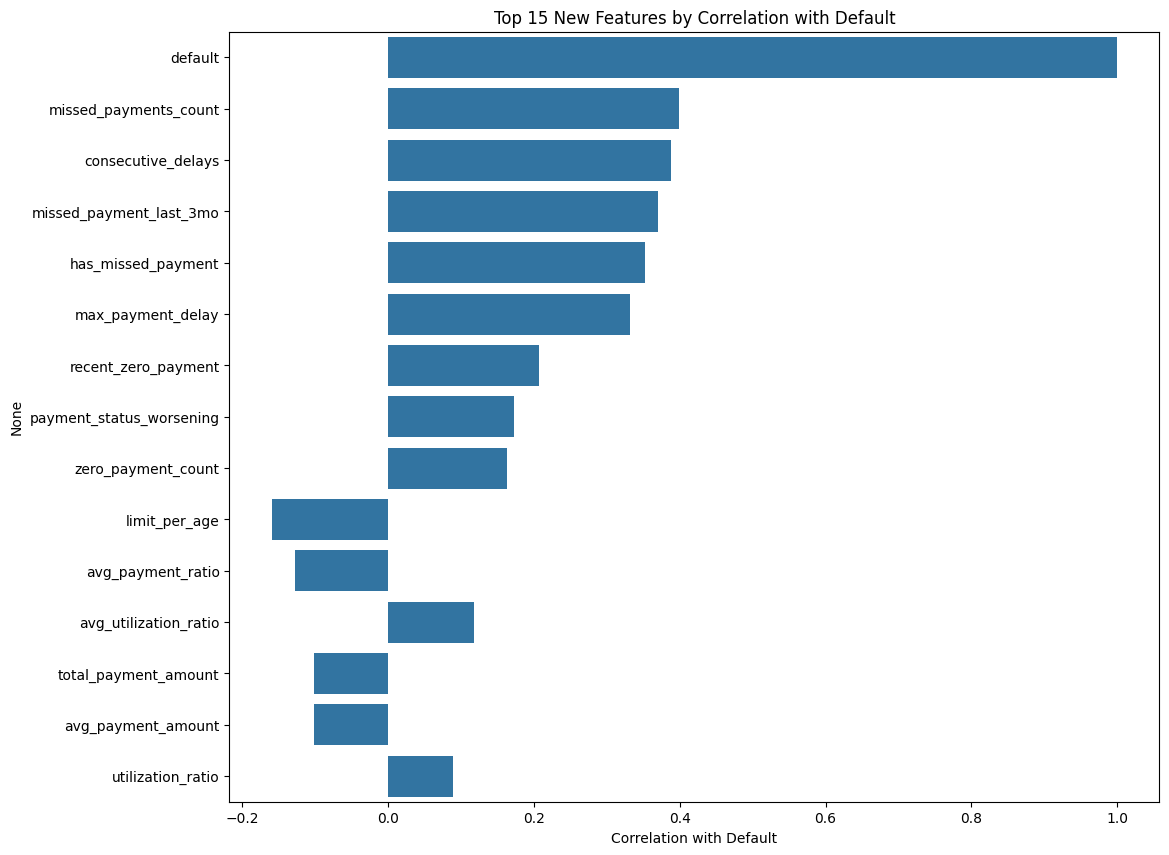

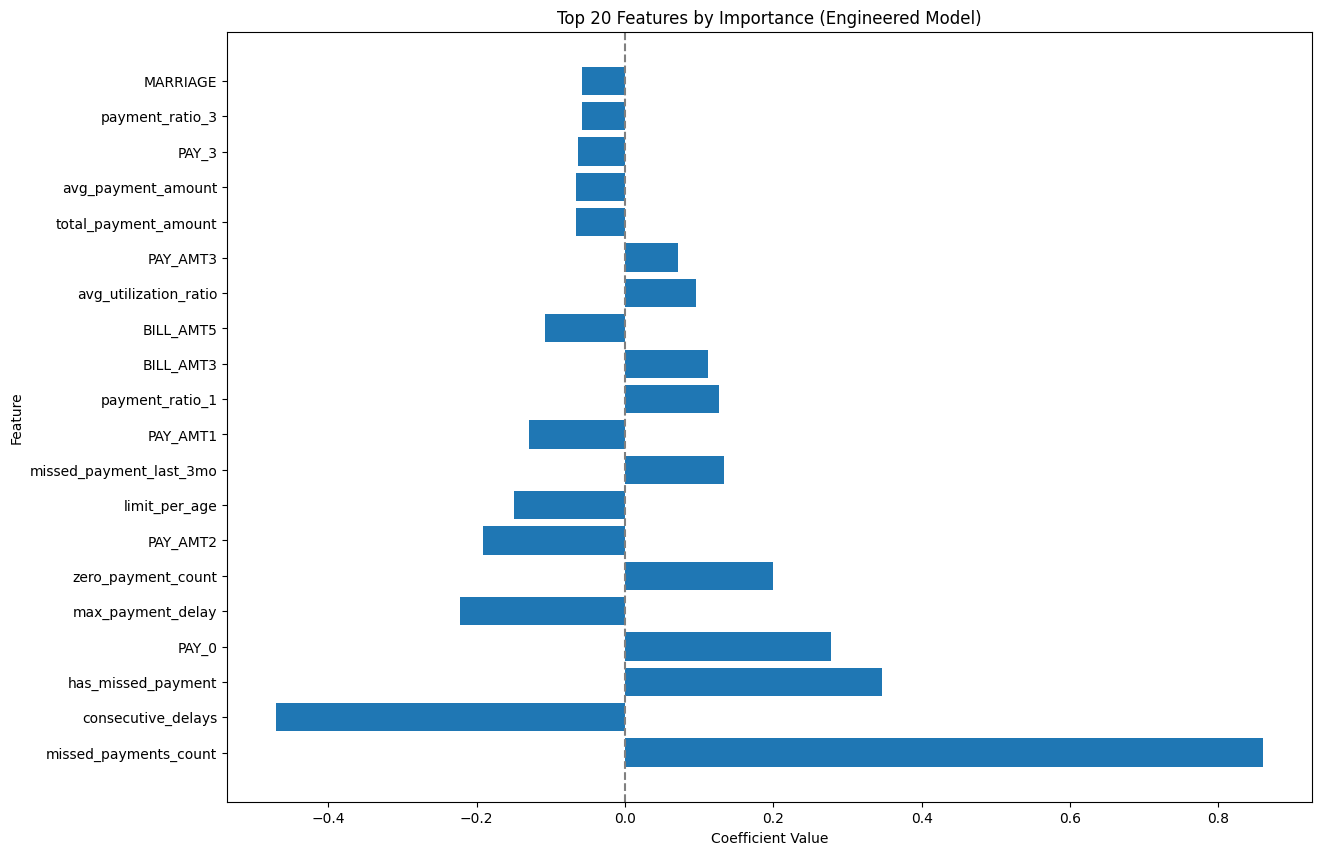


Classification Report (Engineered Model):
              precision    recall  f1-score   support

           0       0.83      0.95      0.89      7009
           1       0.64      0.31      0.42      1991

    accuracy                           0.81      9000
   macro avg       0.73      0.63      0.65      9000
weighted avg       0.79      0.81      0.78      9000



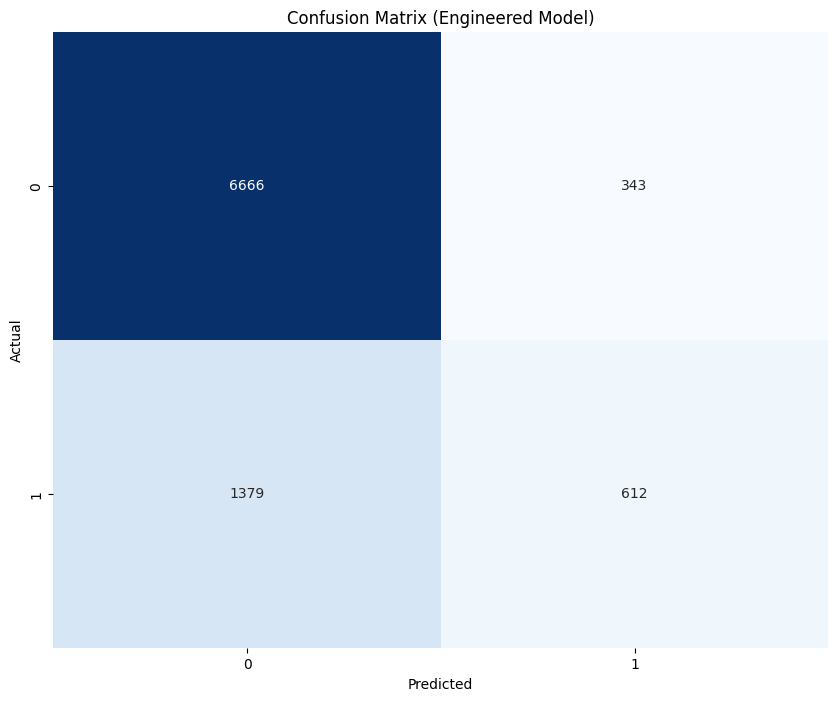

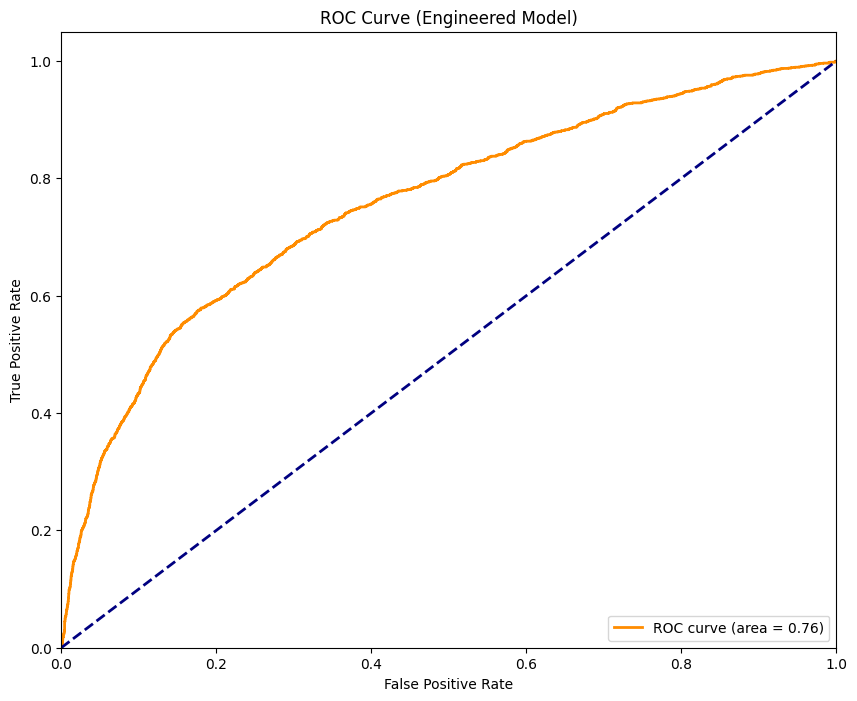


Top 20 Features by Importance:
                    Feature  Coefficient
29    missed_payments_count     0.859889
30       consecutive_delays    -0.470017
32       has_missed_payment     0.346292
5                     PAY_0     0.277001
33        max_payment_delay    -0.222636
36       zero_payment_count     0.199976
18                 PAY_AMT2    -0.191203
37            limit_per_age    -0.149894
31  missed_payment_last_3mo     0.133825
17                 PAY_AMT1    -0.129455
23          payment_ratio_1     0.126056
13                BILL_AMT3     0.112119
15                BILL_AMT5    -0.108514
39    avg_utilization_ratio     0.095348
19                 PAY_AMT3     0.071863
40     total_payment_amount    -0.066422
41       avg_payment_amount    -0.066422
7                     PAY_3    -0.063749
25          payment_ratio_3    -0.058492
3                  MARRIAGE    -0.057601

Feature engineering complete!
Feature-engineered dataset saved to ./data/credit_card_engineered.parquet


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Load the original UCI dataset
df = pd.read_csv('./data/UCI_Credit_Card.csv')
df = df.rename(columns={"default.payment.next.month": "default"})

print("Original shape:", df.shape)

# Feature Engineering
# 1. Payment history related features
payment_cols = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
bill_cols = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
pay_amt_cols = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

# Count of missed payments (payment delay)
df['missed_payments_count'] = (df[payment_cols] > 0).sum(axis=1)

# Has any missed payment
df['has_missed_payment'] = df['missed_payments_count'] > 0

# Has missed payment last 3 months
df['missed_payment_last_3mo'] = (df[['PAY_0', 'PAY_2', 'PAY_3']] > 0).any(axis=1)

# Consecutive months with missed payments
def count_consecutive_delays(row):
    count = 0
    max_consecutive = 0
    for col in payment_cols:
        if row[col] > 0:
            count += 1
        else:
            max_consecutive = max(max_consecutive, count)
            count = 0
    return max(max_consecutive, count)

df['consecutive_delays'] = df.apply(count_consecutive_delays, axis=1)

# Payment status getting worse? (recent month vs. 6 months ago)
df['payment_status_worsening'] = df['PAY_0'] > df['PAY_6']

# Maximum payment delay (higher values indicate longer delays)
df['max_payment_delay'] = df[payment_cols].max(axis=1)

# Payment status improving over the last 3 months?
df['recent_improvement'] = (df['PAY_0'] < df['PAY_3'])

# 2. Bill amount related features
# Total bill amount across all months
df['total_bill_amount'] = df[bill_cols].sum(axis=1)

# Average bill amount
df['avg_bill_amount'] = df[bill_cols].mean(axis=1)

# Bill amount trend (increasing or decreasing) - with safeguards against infinity
df['bill_trend'] = np.where(
    df['BILL_AMT6'] != 0,
    (df['BILL_AMT1'] - df['BILL_AMT6']) / df['BILL_AMT6'].abs(),
    df['BILL_AMT1'].apply(lambda x: 1 if x > 0 else 0)  # If denominator is 0, use sign of numerator
)
# Clip to reasonable range to avoid extreme values
df['bill_trend'] = df['bill_trend'].clip(-10, 10)

# Bill amount volatility
df['bill_volatility'] = df[bill_cols].std(axis=1)

# Last month bill vs. average bill ratio - with safeguards
df['last_bill_vs_avg_ratio'] = np.where(
    df['avg_bill_amount'] != 0,
    df['BILL_AMT1'] / df['avg_bill_amount'],
    df['BILL_AMT1'].apply(lambda x: 1 if x > 0 else 0)
)
df['last_bill_vs_avg_ratio'] = df['last_bill_vs_avg_ratio'].clip(-10, 10)

# 3. Payment amount related features
# Total payment amount
df['total_payment_amount'] = df[pay_amt_cols].sum(axis=1)

# Average payment amount
df['avg_payment_amount'] = df[pay_amt_cols].mean(axis=1)

# Payment amount trend - with safeguards
df['payment_trend'] = np.where(
    df['PAY_AMT6'] != 0,
    (df['PAY_AMT1'] - df['PAY_AMT6']) / df['PAY_AMT6'].abs(),
    df['PAY_AMT1'].apply(lambda x: 1 if x > 0 else 0)
)
df['payment_trend'] = df['payment_trend'].clip(-10, 10)

# Number of months with zero payment
df['zero_payment_count'] = (df[pay_amt_cols] == 0).sum(axis=1)

# Has made any zero payments in the last 3 months
df['recent_zero_payment'] = (df[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3']] == 0).any(axis=1)

# 4. Ratio and utilization features
# Payment to bill ratio (for each month) - with safeguards
for i in range(1, 7):
    bill_col = f'BILL_AMT{i}'
    pay_col = f'PAY_AMT{i}'
    ratio_col = f'payment_ratio_{i}'
    
    # Calculate payment ratio, handling division by zero and negative bill amounts
    df[ratio_col] = np.where(
        (df[bill_col] > 0),  # Only calculate ratio for positive bills
        np.minimum(df[pay_col] / df[bill_col], 5),  # Cap at 500% payment
        np.where(
            df[bill_col] < 0,  # If bill is negative (credit balance)
            0,  # Set to 0 (no payment needed)
            np.where(
                df[pay_col] > 0,  # If bill is 0 but payment was made
                1,  # Set to 1 (full payment)
                0   # Both bill and payment are 0
            )
        )
    )

# Average payment ratio
payment_ratio_cols = [f'payment_ratio_{i}' for i in range(1, 7)]
df['avg_payment_ratio'] = df[payment_ratio_cols].mean(axis=1)

# Minimum payment ratio (worst month)
df['min_payment_ratio'] = df[payment_ratio_cols].min(axis=1)

# Last month's utilization ratio (bill amount / credit limit) - with safeguards
df['utilization_ratio'] = np.where(
    df['LIMIT_BAL'] > 0,
    np.maximum(0, df['BILL_AMT1']) / df['LIMIT_BAL'],  # Only use positive bill amounts
    0  # If no credit limit, set to 0
)
df['utilization_ratio'] = df['utilization_ratio'].clip(0, 1)  # Cap at 100% utilization

# Average utilization ratio
df['avg_utilization_ratio'] = np.where(
    df['LIMIT_BAL'] > 0,
    np.maximum(0, df['avg_bill_amount']) / df['LIMIT_BAL'],
    0
)
df['avg_utilization_ratio'] = df['avg_utilization_ratio'].clip(0, 1)

# 5. Demographic and limit interactions
# Age groups - using integer codes instead of categorical
df['age_group'] = np.where(df['AGE'] < 30, 1,
                 np.where(df['AGE'] < 40, 2,
                 np.where(df['AGE'] < 50, 3,
                 np.where(df['AGE'] < 60, 4, 5))))

# Credit limit per age (younger people with high credit limits might be riskier)
df['limit_per_age'] = df['LIMIT_BAL'] / df['AGE']

# Education-adjusted credit utilization (education level might affect responsible use)
# Handle education level of 0 or other outliers
df['edu_adjusted_utilization'] = np.where(
    (df['EDUCATION'] > 0) & (df['EDUCATION'] <= 4),  # Use only valid education levels
    df['utilization_ratio'] / df['EDUCATION'],
    df['utilization_ratio']  # If invalid education level, just use utilization
)

# Check for infinity or NaN values in the dataframe and replace them
df = df.replace([np.inf, -np.inf], np.nan)
numeric_cols = df.select_dtypes(include=np.number).columns
df[numeric_cols] = df[numeric_cols].fillna(0)  # Replace NaN only in numeric columns

print("Shape after feature engineering:", df.shape)

# Check correlations with target for our new features
new_features = [
    'missed_payments_count', 'has_missed_payment', 'missed_payment_last_3mo',
    'consecutive_delays', 'payment_status_worsening', 'max_payment_delay',
    'recent_improvement', 'total_bill_amount', 'avg_bill_amount', 'bill_trend',
    'bill_volatility', 'last_bill_vs_avg_ratio', 'total_payment_amount',
    'avg_payment_amount', 'payment_trend', 'zero_payment_count',
    'recent_zero_payment', 'avg_payment_ratio', 'min_payment_ratio',
    'utilization_ratio', 'avg_utilization_ratio', 'limit_per_age',
    'edu_adjusted_utilization', 'age_group'
]

# Calculate correlations with target
target_correlations = df[new_features + ['default']].corr()['default'].sort_values(ascending=False)
print("\nCorrelations with default for new features:")
print(target_correlations)

# Plot correlations with target for top 15 features
plt.figure(figsize=(12, 10))
top_features = target_correlations.abs().nlargest(15).index
sns.barplot(x=target_correlations[top_features].values, y=top_features)
plt.title('Top 15 New Features by Correlation with Default')
plt.xlabel('Correlation with Default')
plt.savefig('./img/new_features_correlation.png')
plt.show()

# Prepare data for modeling with the engineered features
# Drop redundant columns and select only useful features
original_features = [col for col in df.columns if col not in new_features + ['ID', 'default']]

# Select top 15 most correlated new features
top_new_features = list(top_features)
if 'default' in top_new_features:
    top_new_features.remove('default')

# Combine original and new features for modeling
selected_features = original_features + top_new_features

# Split data
X = df[selected_features]
y = df['default']

# Final check for any remaining infinite values
X = X.replace([np.inf, -np.inf], 0)
X = X.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Calculate feature importance
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

# Plot feature importance for top features
plt.figure(figsize=(14, 10))
top_20_features = coef_df.head(20)
plt.barh(top_20_features['Feature'], top_20_features['Coefficient'])
plt.axvline(x=0, color='gray', linestyle='--')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 20 Features by Importance (Engineered Model)')
plt.savefig('./img/engineered_feature_importance.png')
plt.show()

# Evaluate model
print("\nClassification Report (Engineered Model):")
print(classification_report(y_test, y_pred))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Engineered Model)')
plt.savefig('./img/engineered_confusion_matrix.png')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Engineered Model)')
plt.legend(loc='lower right')
plt.savefig('./img/engineered_roc_curve.png')
plt.show()

# Print top 20 features by importance
print("\nTop 20 Features by Importance:")
print(top_20_features[['Feature', 'Coefficient']])

print("\nFeature engineering complete!")

# Save the feature-engineered dataframe to parquet format
df.to_parquet('./data/credit_card_engineered.parquet')
print("Feature-engineered dataset saved to ./data/credit_card_engineered.parquet")